In [61]:
from torch import nn , save , load
import torch
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [62]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [63]:
X = np.load("X.npy", allow_pickle=True)
y = np.load("y.npy", allow_pickle=True)
y.shape

(999,)

In [64]:
X/=255.0
X = torch.tensor(X, dtype=torch.float32)
X.shape

torch.Size([999, 31, 128])

In [65]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
y=le.fit_transform(y)
y = torch.tensor(y)
y

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
class NN_model(nn.Module):
    def __init__(self,input_size,hidden1_size,hidden2_size,hidden3_size,hidden4_size,output_size):
        super(NN_model,self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden1_size)
        self.fc2 = torch.nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = torch.nn.Linear(hidden2_size, hidden3_size)
        self.fc4 = torch.nn.Linear(hidden3_size, hidden4_size)
        self.fc5 = torch.nn.Linear(hidden4_size, output_size)

    def forward(self,x):
        out = F.leaky_relu(self.fc1(x))
        out = F.leaky_relu(self.fc2(out))
        out = F.leaky_relu(self.fc3(out))
        out = F.leaky_relu(self.fc4(out))
        out = self.fc5(out)
        return out

In [68]:
X_train.shape[1]

31

In [69]:
input_size = X_train.shape[1]*X_train.shape[2]
# hidden1_size = 512
# hidden2_size = 128

hidden1_size = 2048
hidden2_size = 1024
hidden3_size = 512
hidden4_size = 256
num_classes = 10

In [70]:
# Checking if working correctly or not
model = NN_model(input_size, hidden1_size,hidden2_size,hidden3_size=hidden3_size,hidden4_size=hidden4_size, output_size=num_classes).to(device)
print(model)

NN_model(
  (fc1): Linear(in_features=3968, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=10, bias=True)
)


In [80]:
num_epochs = 45
batch_size = 16
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [81]:
print(X_train.shape)
print(y_train.shape)

torch.Size([799, 31, 128])
torch.Size([799])


In [82]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [83]:
n_total_steps = len(train_loader)
train_loss = []
for epoch in range(num_epochs):
    for i, (embeddings,labels) in enumerate(train_loader):
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        embeddings = embeddings.reshape(embeddings.shape[0],-1)
        # Forward pass
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            train_loss.append(loss.item())

In [84]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} from {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    # model.train()
    
check_accuracy(train_loader, model)

Got 797 from 799 with accuracy 99.75


<Axes: >

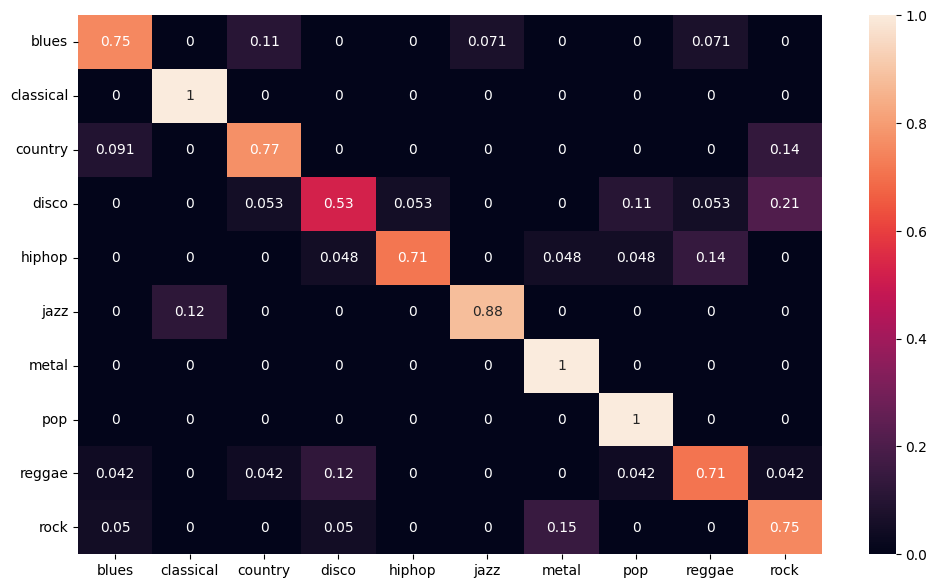

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():

  for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          inputs = inputs.reshape(inputs.shape[0], -1)

          output = model(inputs)

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ("blues" , "classical" , "country" , "disco" , "hiphop" , "jazz" , "metal" , "pop" , "reggae" , "rock")

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [86]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix , classification_report
acc = accuracy_score(y_pred,y_true) * 100
report=classification_report(y_true, y_pred,target_names = classes)
print(f"Accuracy = {acc:.2f}%")
print("Classification Report: \n",report)

Accuracy = 79.50%
Classification Report: 
               precision    recall  f1-score   support

       blues       0.84      0.75      0.79        28
   classical       0.92      1.00      0.96        22
     country       0.77      0.77      0.77        22
       disco       0.67      0.53      0.59        19
      hiphop       0.94      0.71      0.81        21
        jazz       0.88      0.88      0.88        17
       metal       0.75      1.00      0.86        12
         pop       0.79      1.00      0.88        15
      reggae       0.74      0.71      0.72        24
        rock       0.65      0.75      0.70        20

    accuracy                           0.80       200
   macro avg       0.79      0.81      0.80       200
weighted avg       0.80      0.80      0.79       200

